# Minimal Plotting Example for CMAQ Output

**Author:** Michael Needham, US EPA Region 7 Air and Radiation Division

**Contact:** __needham.michael@epa.gov__

**Description:** Shows a minimal working example to take output from a CMAQ simulation formatted by IOAPI to make a basic plot in python using the __[xarray](https://docs.xarray.dev/en/stable/)__, __[matplotlib](https://matplotlib.org/)__, and __[cartopy](https://scitools.org.uk/cartopy/docs/latest/)__ packages.

**Last Updated:** 12 July 2024

In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import xarray as xr

ERROR 1: PROJ: proj_create_from_database: Open of /work/REGIONS/users/mneedham/.miniforge3/envs/cmaq_pyenv/share/proj failed


## 1. Function Definitions

<div class="alert alert-block alert-info">
Use these functions (collected into the final, <code>get_cmaq_metadata</code> function) to add spatial and temporal information to the CMAQ output file(s) after reading with xarray. This assumes that the files were written using <b><a href="https://www.cmascenter.org/ioapi/">I/O API</a></b>. The functions are included inline here so that this notebook is entirely self-contained, but note that in future notebooks, these functions are collected into the separate <code>src/utils/cmaq</code> python module which are used with python import statements. For example: <code>from src.utils.cmaq import get_cmaq_metadata</code>

<i>Note that this requires installing the package with <code>pip install .</code> from the base directory of this project. See the main</i> <b><a href="../README.md">README</a></b> <i>for details</i>
</div>

In [2]:
def display_vars(dset, var_dsec="var_desc"):
    """Displays variables, units, and descriptions of an xarray dataset

    Generates a printout of each variable within dset that includes the
    variable name, the units, and an extended description of the variable (if
    available).

    Parameters
    ----------
    dset : xarray.Dataset
        Target dataset. It is possible to call `display_vars` on an unformatted
        `dset` e.g., display_vars(xr.open_dataset(file)), or on a formatted
        `dset` e.g., display_vars(get_cmaq_metadata(xr.open_dataset(file))).

    var_dsec : string, default='var_desc'
        Name of the attribute for the xarray.DataArray instances within `dset`
        which contains a description of the variable

    Returns
    -------
    None

    See Also
    -------
    cmaq.get_cmaq_metadata
    """

    var = "VARNAME"
    units = "UNITS"
    desc = "DESCRIPTION"

    print("-" * 80)
    print(f"| {var:8} | {units:16} | {desc}")
    print("-" * 80)

    ct = 1
    for var in list(dset.data_vars):
        desc = ""
        units = ""

        try:
            desc = getattr(dset[var], var_dsec)
        except:
            pass

        try:
            units = dset[var].units
        except:
            pass

        print(f"| {var:8} | {units:16} | {desc}")

        if ct % 6 == 0:
            print("-" * 80)

        ct += 1

    return None


def get_cmaq_xy(dset):
    """Generate x and y coordinate arrays for cmaq-formatted data

    Interpret attributes of the input file to generate x and y
    coordinate arrays based on the number of gridcells in the x- and
    y-directions, and the size of the gridcells in in those directions
    (which will typically be identical, but in general could be
    different).

    Parameters
    ----------
    dset : xarray.Dataset
        result of calling xr.open_dataset() on a netcdf file in cmaq format

    Returns
    -------
    xcoords : numpy.array
        coordinate array for the x dimension

    ycoords : numpy.array
        coordinate array for the y dimension
    """

    xcoords = np.arange(
        0, (dset.attrs["XCELL"] * dset.attrs["NCOLS"]), dset.attrs["XCELL"]
    )

    ycoords = np.arange(
        0, dset.attrs["YCELL"] * dset.attrs["NROWS"], dset.attrs["YCELL"]
    )

    return xcoords, ycoords


def get_cmaq_datetime(dset, is_jday=True):
    """Generate datetime coordinate array for cmaq-formatted data

    Interpret attributes of the input file to generate datetime
    coordinate array based on the number of timesteps, the size of the
    timestep, and the starting date and time

    Parameters
    ----------
    dset : xarray.Dataset
        result of calling xr.open_dataset() on a file in cmaq format

    is_jday : bool, default=True
        flag to indicate if input dates use the Julian (YYYYJJJ) or the
        Gregorian (YYYYMMDD) calendar format. Note that even if
        is_jday=True, the resulting datetime coordinate array will use
        the defauly pandas gregorian calendar. In other words, this
        flag is only used to interpret input dates, not to set output
        dates.

    Returns
    -------
    datetimes : pandas.Series
        datetime coordinate array, parsed to pandas gregorian datetime
        format.
    """

    ntstep = len(dset.TSTEP)

    times = np.arange(
        dset.attrs["STIME"], dset.attrs["TSTEP"] * ntstep, dset.attrs["TSTEP"]
    )

    start_date = dset.attrs["SDATE"]
    date_inc = -1
    datetimes = []

    for time in times % 240000:
        if time == 0:
            date_inc += 1

        datetimes.append(f"{start_date+date_inc}T{time:0>6}")

    if is_jday:
        date_format = "%Y%jT%H%M%S"
    else:
        date_format = "%Y%m%dT%H%M%S"

    datetimes = pd.to_datetime(datetimes, format=date_format)

    return datetimes


def get_cmaq_projection(dset, proj_type="lambert"):
    """Create a cartopy lambert projection object from dataset metadata"""

    if proj_type == "lambert":
        # Generate the projection
        proj = ccrs.LambertConformal(
            central_latitude=dset.attrs["YCENT"],
            central_longitude=dset.attrs["XCENT"],
            standard_parallels=(dset.attrs["P_ALP"], dset.attrs["P_BET"]),
            false_easting=-dset.attrs["XORIG"],
            false_northing=-dset.attrs["YORIG"],
        )

    elif (proj_type == "mercator") or (proj_type == "polar"):
        raise NotImplementedError(f'projection: "{proj_type}" not yet implemented')

    else:
        raise ValueError(
            f"""
        Invalid projection: {proj_type}.
        Choose a valid projection: [\'lambert\', \'mercator\', \'polar\']
        """
        )

    return proj


def get_cmaq_metadata(dset, is_jday=True, return_proj=False):
    """Interpret and add coordinate arrays to cmaq-formatted data

    Interpret attributes of the input file to generate datetime
    coordinate array based on the number of timesteps, the size of the
    timestep, and the starting date and time

    Parameters
    ----------
    dset : xarray.Dataset
        result of calling xr.open_dataset() on a file in cmaq format

    is_jday : bool, default=True
        parameter passed to get_cmaq_datetime()

    Returns
    -------
    dset : xarray.Dataset
        the same input dataset, but with added coordinate arrays

    proj_lamb : cartopy.crs.LambertConformal
        a cartopy Lambert conformal conic projection with parameters
        set by the input dataset attributes, for use in plotting
    """

    # Get coordinate arrays associated with the x-, y-, and time-dimensions
    xcoords, ycoords = get_cmaq_xy(dset)
    datetimes = get_cmaq_datetime(dset, is_jday=is_jday)

    # Add the coordinate arrays and rename the output
    dset = dset.assign_coords({"COL": xcoords, "ROW": ycoords, "TSTEP": datetimes})
    dset = dset.rename({"ROW": "y", "COL": "x", "TSTEP": "time"})

    if return_proj:

        proj = get_cmaq_projection(dset)

        return dset, proj

    return dset

## 2. File I/O



In [3]:
file = Path(
    "./tutorial_data/CMAQv54_cb6r5_ae7_aq.36US3.35.DDM_2022_36US3.011.AELMO.2022217/"
)

dset = get_cmaq_metadata(xr.open_dataset(file))
proj = get_cmaq_projection(dset, proj_type="lambert")

# Display the dataset in HTML format
print(f"Dataset size: {dset.nbytes / 1e9:>.3f} GB")
dset

Dataset size: 0.042 GB


<xarray.Dataset> Size: 42MB
Dimensions:  (time: 24, VAR: 17, DATE-TIME: 2, LAY: 1, y: 148, x: 172)
Coordinates:
  * x        (x) float64 1kB 0.0 3.6e+04 7.2e+04 ... 6.12e+06 6.156e+06
  * y        (y) float64 1kB 0.0 3.6e+04 7.2e+04 ... 5.256e+06 5.292e+06
  * time     (time) datetime64[ns] 192B 2022-08-05 ... 2022-08-05T23:00:00
Dimensions without coordinates: VAR, DATE-TIME, LAY
Data variables: (12/18)
    TFLAG    (time, VAR, DATE-TIME) int32 3kB ...
    NO2      (time, LAY, y, x) float32 2MB ...
    FORM     (time, LAY, y, x) float32 2MB ...
    SO2      (time, LAY, y, x) float32 2MB ...
    O3       (time, LAY, y, x) float32 2MB ...
    PM25     (time, LAY, y, x) float32 2MB ...
    ...       ...
    ZH       (time, LAY, y, x) float32 2MB ...
    CFRAC    (time, LAY, y, x) float32 2MB ...
    PV       (time, LAY, y, x) float32 2MB ...
    CO       (time, LAY, y, x) float32 2MB ...
    NH3      (time, LAY, y, x) float32 2MB ...
    AOD_550  (time, LAY, y, x) float32 2MB ...
Attributes: (12/33)
    IOAPI_VERSION:  ioapi-3.2: $Id: init3.F90 247 2023-03-22 15:59:19Z coats ...
    EXEC_ID:        ????????????????                                         ...
    FTYPE:          1
    CDATE:          2024156
    CTIME:          190724
    WDATE:          2024156
    ...             ...
    VGLVLS:         [1.     0.9975]
    GDNAM:          36US3           
    UPNAM:          OPEN_ELMO       
    VAR-LIST:       NO2             FORM            SO2             O3       ...
    FILEDESC:       Parameters Relevant for PM Formation and Distribution    ...
    HISTORY:

In [4]:
display_vars(dset)

--------------------------------------------------------------------------------
| VARNAME  | UNITS            | DESCRIPTION
--------------------------------------------------------------------------------
| TFLAG    | <YYYYDDD,HHMMSS> | Timestep-valid flags:  (1) YYYYDDD or (2) HHMMSS                                
| NO2      | ppmV             | Average Molar Mixing Ratio of NO2                                               
| FORM     | ppmV             | Average Molar Mixing Ratio of FORM                                              
| SO2      | ppmV             | Average Molar Mixing Ratio of SO2                                               
| O3       | ppmV             | Average Molar Mixing Ratio of O3                                                
| PM25     | ug m-3           | Bulk PM2.5 Concentration                                                        
--------------------------------------------------------------------------------
| PM10     | ug m-3           | Bul

## 3. Generate Plots

### 3.A Minimal Working Example
> Shows an example of a simple plot that can be made from the output data, primarily using default parameters

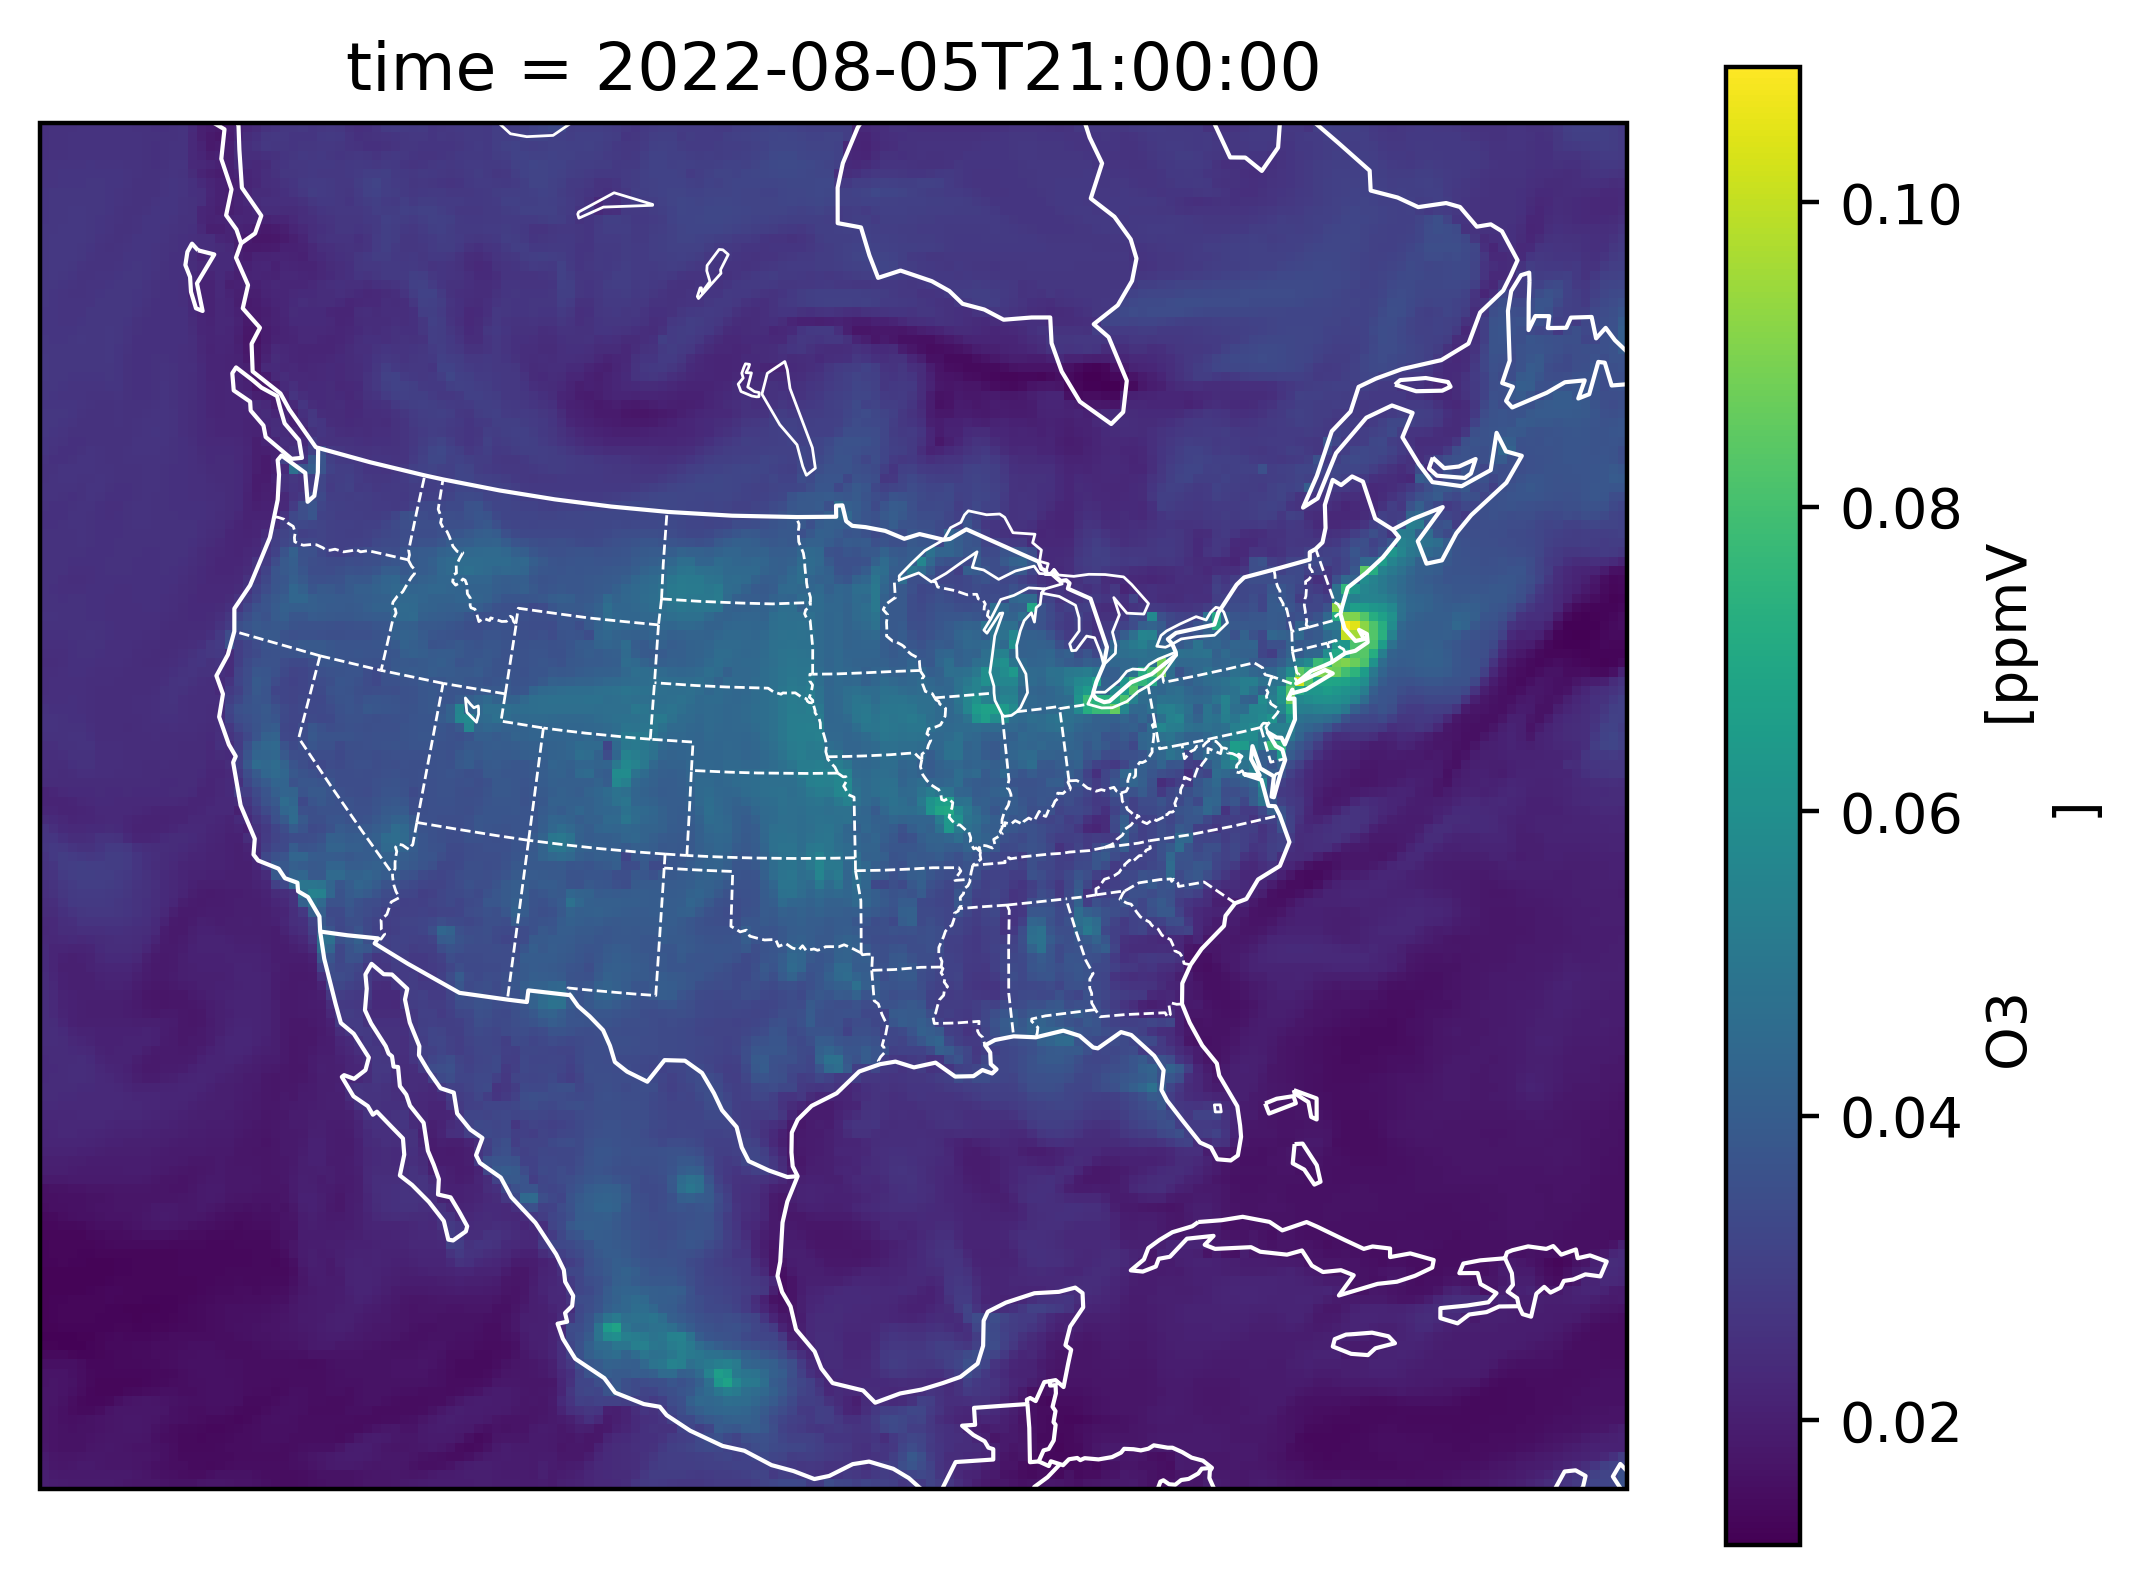

In [5]:
# ============================================================================
# MINIMAL PLOTTING EXAMPLE
# ============================================================================

# Use cartopy feature interface to download shapefiles for USA/CANADA
# state and province boundaries
states_provinces = cfeature.NaturalEarthFeature(
    category="cultural",
    name="admin_1_states_provinces_lines",
    scale="110m",
)

# ----------------------------------------------------------------------------

# defauly to plotting hourly ozone
plot_variable = "O3"

# Plot with matplotlib using cartopy interface. Specify the map projection
# for each subplot (only 1 subplot in this case, but generalizes to additional
# subplots) with the subplot_kw argument. DPI is "dots per inch" and controls
# the resolution of the resulting image.
fig, ax = plt.subplots(subplot_kw={"projection": proj}, dpi=400)

# Make a map of the plotting variable. This uses xarray's plotting
# interface (e.g., dataarray.plot()) which is a wrapper around
# matplotlib and is equivalent to plt.pcolormesh()
dset[plot_variable].isel(
    {"time": 21, "LAY": 0}  # use da.isel to select by coordinate index
).plot(ax=ax)

# Add features for spatial orientation
ax.add_feature(cfeature.BORDERS, ec="w", fc="none", lw=0.75)
ax.add_feature(cfeature.LAKES.with_scale("110m"), ec="w", fc="none", lw=0.5)
ax.add_feature(states_provinces, ec="w", fc="none", lw=0.5, ls="--")
ax.coastlines(color="w", lw=0.75)

plt.show()

### 3.B An additional plotting example, showing more customizations

#### 3.B.1 Custom Colormap

This example uses the `magma` colormap, which is a __[perceptually uniform](https://colorcet.com/)__ colormap included with matplotlib. For additional colormap options included by default, see the __[matplotlib documentation](https://matplotlib.org/stable/users/explain/colors/colormaps.html)__.

The process is to specify specific breakpoints (here, we use breakpoints that are linearly spaced, but this is not a requirement) across the range of our data which will be used to map our data to specific colors based on the magma colorbar. This mapping / normalization is performed using __[matplotlib.colors.BoundaryNorm](https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.BoundaryNorm.html)__, and we then draw the colorbar onto the plot with this scaling using __[matplotlib.cm.ScalarMappable](https://matplotlib.org/stable/api/cm_api.html#matplotlib.cm.ScalarMappable)__

Colormap breakpoints: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18.]


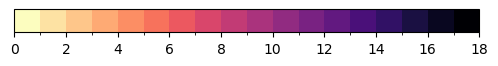

In [6]:
# Setup the desired colorbar
vmin = 0
vmax = 18
dlev = 1
levels = np.arange(vmin, vmax + dlev / 2, dlev)

cmap = mpl.colormaps["magma_r"]
norm = mpl.colors.BoundaryNorm(ncolors=cmap.N, boundaries=levels)
smap = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)

print(f"Colormap breakpoints: {levels}")

# These two lines are just included to dispaly the colorbar
fig, ax = plt.subplots(figsize=(6, 0.3))
fig.colorbar(smap, cax=ax, orientation="horizontal")

#### 3.B.2 Make The Plot

Other (minor) changes:
* Show PM2.5 instead of O3
* Explicitly make the meshplot with __[matplotlib.pyplot.pcolormesh](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pcolormesh.html)__
* Labeling (minimize hardcoding variables whenever possible; instead, draw label information from metadata stored in xarray objects)
    * Add a title
    * Add datetime information
    * Add a label to the colorbar

In [7]:
# --- Prepare Plotting Data ---------------------------------------------------
plot_variable = "PM25"

# Show two plots as an example
plot_data_1 = dset[plot_variable].isel({"time": 12, "LAY": 0})
plot_data_2 = dset[plot_variable].isel({"time": 18, "LAY": 0})

# Store as a list for easier looping
plot_data = [plot_data_1, plot_data_2]

# --- Cartopy Features --------------------------------------------------------
states_provinces = cfeature.NaturalEarthFeature(
    category="cultural",
    name="admin_1_states_provinces_lines",
    scale="110m",
)


# Define this outside of the main plotting call for the sake of neatness
def add_features(ax, color="k"):
    # Add features for spatial orientation
    ax.add_feature(cfeature.BORDERS, ec=color, fc="none", lw=0.75)
    ax.add_feature(cfeature.LAKES.with_scale("110m"), ec=color, fc="none", lw=0.75)
    ax.add_feature(states_provinces, ec=color, fc="none", lw=0.5, ls="--")
    ax.coastlines(color=color, lw=0.75)

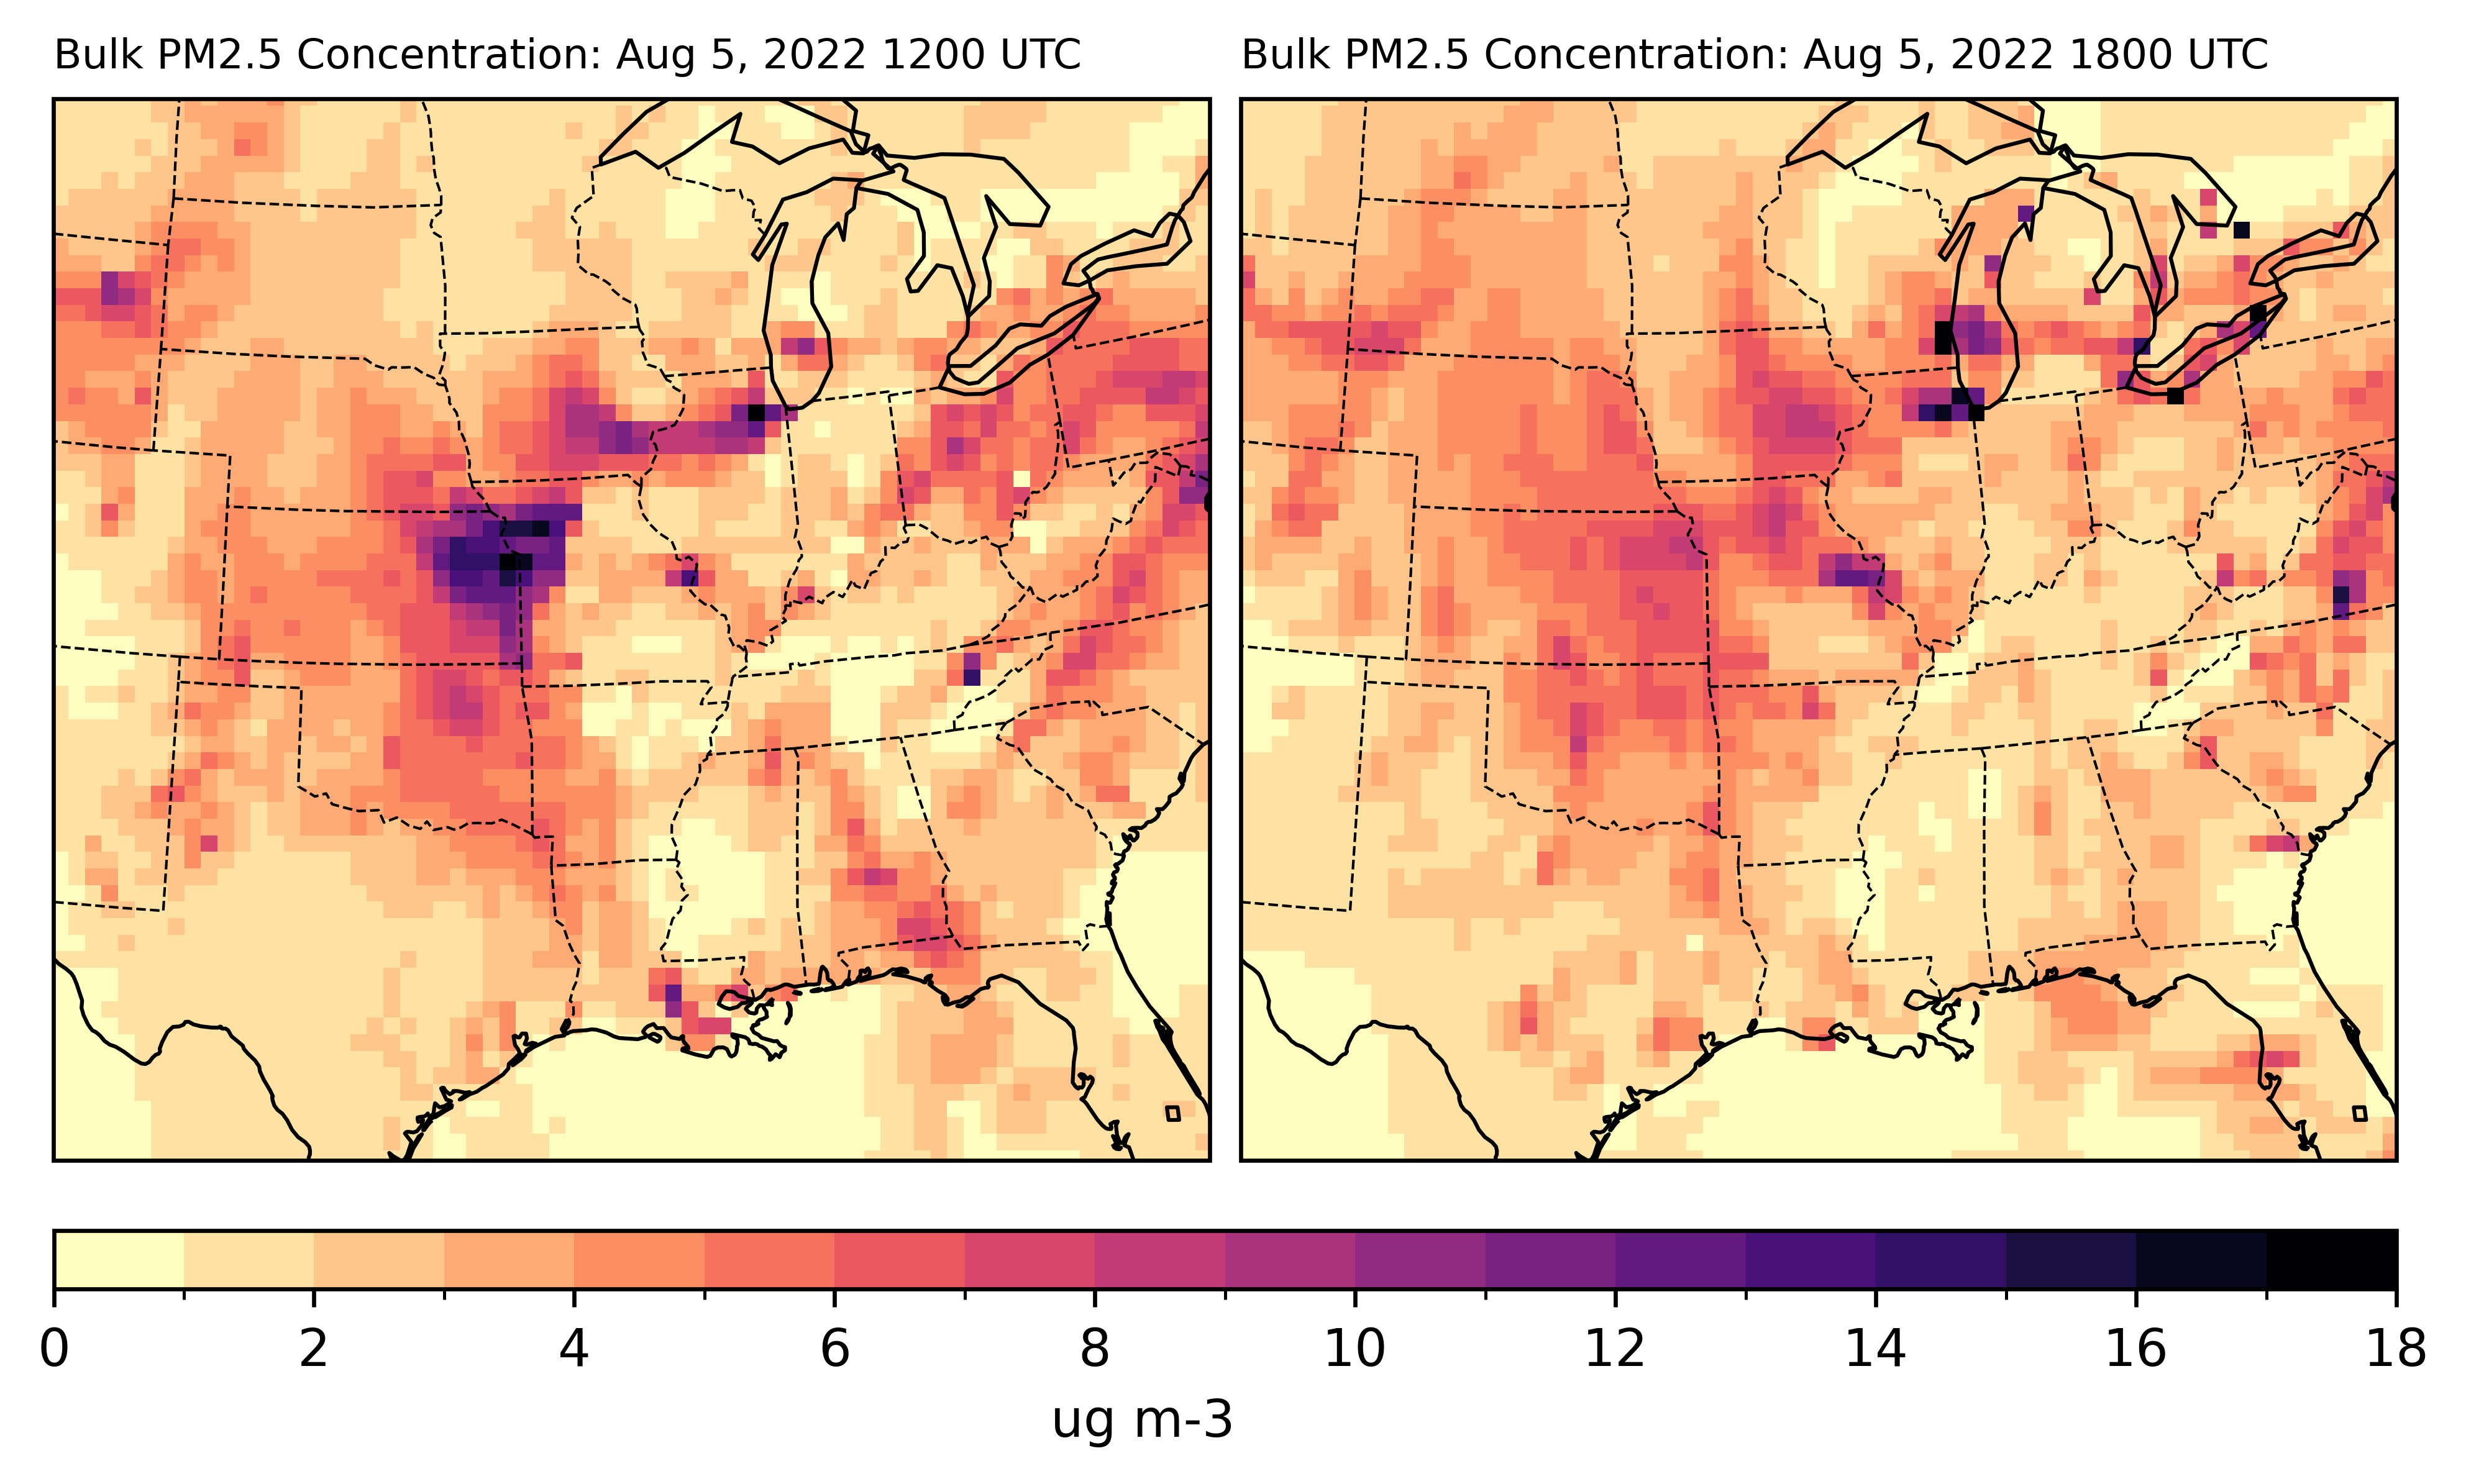

In [8]:
fig, axs = plt.subplots(
    subplot_kw={"projection": proj},
    dpi=600,
    figsize=(6.5, 4),
    layout="constrained",  # This removes whitespace between plots
    ncols=2,
)

for data, ax in zip(plot_data, axs):

    disp_time = pd.to_datetime(data.time.data).strftime("%b %-d, %Y %H%M UTC")
    add_features(ax)
    ax.set_extent([-105, -80, 27, 47], crs=ccrs.PlateCarree())

    ax.pcolormesh(data.x, data.y, data, cmap=cmap, norm=norm, transform=proj)
    ax.set_title(data.var_desc.strip() + f": {disp_time}", loc="left", fontsize=8)

# Add the colorbar. Use ax=axs to stretch the colorbar across the bottom of
# both axes. Could alternatively add a separate colorbar to each plot for
# portability by moving this call within the for loop and changing "ax=axs" to
# "ax=ax"
cbar = fig.colorbar(smap, ax=axs, location="bottom", pad=0.05, aspect=40)
cbar.set_label(data.units)

plt.show()

Next Up: __[Example 2](./02_hr2day_output_analysis_example.ipynb)__ for additional plotting examples based on CMAQ daily output generated using the __[CMAQ/POST/hr2day](https://github.com/USEPA/CMAQ/tree/main/POST/hr2day)__ postprocessing tool.